In [1]:
from math import sqrt

import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
def generate_rnorms(N, Ws, params_list):
    rnorms = [np.random.normal(params[0], params[1], round(N*w)) for params, w in zip(params_list, Ws)]
    mix = np.concatenate(rnorms)
    mix_strs = [f'{w}×N({params[0]}, {params[1]})' for params, w in zip(params_list, Ws)]
    print (' + '.join(mix_strs))
    _ = sns.kdeplot(mix, bw=0.5)
    return rnorms

In [3]:
def print_modelling_and_estimation_results(choice, iters, n, rnorms, Ws, params_list):
    print(f'Choice: {choice}')
    if choice.startswith('stratify'):
        strat_sample_sizes = get_strat_sample_sizes(n, Ws, params_list, strategy=choice.rsplit('_', 1)[1])
        n = strat_sample_sizes
        print(f'Strat samples sizes: {n}')
    
    print('Modelling results')
    modelling_stats = model_point_estimates(choice, iters, n, rnorms)
    print_stats(modelling_stats)
    
    if choice.startswith('stratify'):
        print('Estimation results')
        estimation_stats = estimate_point_estimates(rnorms, strat_sample_sizes, Ws)
        print_stats(estimation_stats)

def print_stats(stats):
    print(f'\tMean mean: {stats[0]}')
    print(f'\tMean variance: {stats[1]}')
    print(f'\tVariance mean: {stats[2]}')
    print(f'\tVariance variance: {stats[3]}')

In [4]:
def get_strat_sample_sizes(n, Ws, params_list, strategy):
    if strategy == 'prop':
        nks = [int(n * w) for w in Ws]
    elif strategy == 'optimal':
        np_Ws = np.array(Ws)
        np_sigmas = np.array([sqrt(sigma_square) for _, sigma_square in params_list])
        props = np.divide(np.multiply(np_Ws, np_sigmas), np.dot(np_Ws, np_sigmas))
        nks = [int(round(n * prop)) for prop in props]
    return nks

In [5]:
def model_point_estimates(choice, iters, n, rnorms):
    """Models point estimates by repeated sampling.
    
    If `choice` is stratification based `n` is expected to be list of strat sample sizes. 
    """
    means = []
    variances = []
    for i in range(iters):    
        if choice == 'simple':
            mix = np.concatenate(rnorms)
            sample = np.random.choice(mix, n)
            means.append(np.mean(sample))
            variances.append(np.var(sample))
        elif choice.startswith('stratify'):
            strat_samples = [np.random.choice(rnorm, nk) for rnorm, nk in zip(rnorms, n)]
            strat_mix = np.concatenate(strat_samples)
            means.append(np.mean(strat_mix))
            variances.append(np.var(strat_mix))
    return np.mean(means), np.var(means), np.mean(variances), np.var(variances)

In [6]:
def estimate_point_estimates(rnorms, strat_sample_sizes, Ws):
    strat_samples = [np.random.choice(rnorm, nk) for rnorm, nk in zip(rnorms, strat_sample_sizes)]
    strat_means = np.array([np.mean(sample) for sample in strat_samples])
    strat_vars = np.array([np.var(sample) for sample in strat_samples])
    w = np.array(Ws)
    strats_number = len(strat_sample_sizes)
    
    mean_mean = np.dot(w, np.full(strats_number, np.mean(strat_means)))
    mean_var = np.dot(np.square(w), np.full(strats_number, np.var(strat_means)))
    w_dot_mean_minus_mean = np.subtract(np.dot(w, strat_means), strat_means)
    var_mean = np.add(np.dot(w, np.full(strats_number, np.mean(strat_vars))), np.dot(w, np.full(strats_number, np.square(np.mean(w_dot_mean_minus_mean)))))
    var_var = np.add(np.dot(np.square(w), np.full(strats_number, np.var(strat_vars))), np.var(np.dot(w, np.square(w_dot_mean_minus_mean))))
    
    return mean_mean, mean_var, var_mean, var_var

In [7]:
_iters = 1000
_N = 500
_n = 40
_Ws = [0.3, 0.5, 0.2]

### Same means and vars

0.3×N(3, 1) + 0.5×N(3, 1) + 0.2×N(3, 1)


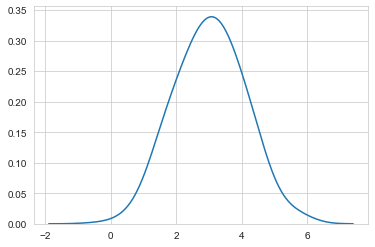

In [8]:
_params_list = [(3, 1), (3, 1), (3, 1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [9]:
print_modelling_and_estimation_results('simple', _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 3.020091353472777
	Mean variance: 0.025920793196085826
	Variance mean: 1.0492679521815127
	Variance variance: 0.051417462421896404


##### Stratified proportionally

In [10]:
print_modelling_and_estimation_results('stratify_prop', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_prop
Strat samples sizes: [12, 20, 8]
Modelling results
	Mean mean: 3.0239737875064656
	Mean variance: 0.02831026264408964
	Variance mean: 1.0373850651336312
	Variance variance: 0.05545618630076314
Estimation results
	Mean mean: 2.9315692843292154
	Mean variance: 0.011817028339294381
	Variance mean: 0.9259126929864123
	Variance variance: 0.004628296729102169


##### Stratified optimally

In [11]:
print_modelling_and_estimation_results('stratify_optimal', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_optimal
Strat samples sizes: [12, 20, 8]
Modelling results
	Mean mean: 3.0171923738486757
	Mean variance: 0.025337776714294456
	Variance mean: 1.0341177126685877
	Variance variance: 0.051437821156900196
Estimation results
	Mean mean: 2.958594490782146
	Mean variance: 0.013482074569907564
	Variance mean: 0.6484536100754826
	Variance variance: 0.0021557168217508603


### Different means same vars

0.3×N(0, 1) + 0.5×N(10, 1) + 0.2×N(3, 1)


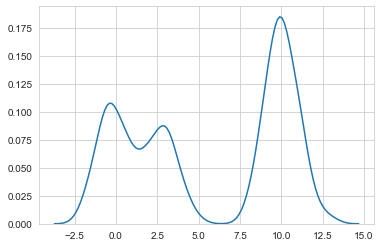

In [12]:
_params_list = [(0, 1), (10, 1), (3, 1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [13]:
print_modelling_and_estimation_results('simple', _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 5.538322193440561
	Mean variance: 0.5710062857918579
	Variance mean: 21.40899613205127
	Variance variance: 4.624178523127801


##### Stratified proportionally

In [14]:
print_modelling_and_estimation_results('stratify_prop', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_prop
Strat samples sizes: [12, 20, 8]
Modelling results
	Mean mean: 5.597859866841256
	Mean variance: 0.02291275137636228
	Variance mean: 21.91009636427045
	Variance variance: 1.9892625847388958
Estimation results
	Mean mean: 4.229290646314622
	Mean variance: 6.8363806931249576
	Variance mean: 2.584154071473655
	Variance variance: 0.011777845372267707


##### Stratified optimally

In [15]:
print_modelling_and_estimation_results('stratify_optimal', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_optimal
Strat samples sizes: [12, 20, 8]
Modelling results
	Mean mean: 5.5903155098404005
	Mean variance: 0.023550104899454232
	Variance mean: 21.916987842541698
	Variance variance: 2.088592127912947
Estimation results
	Mean mean: 4.400111676726415
	Mean variance: 6.863536352513318
	Variance mean: 2.185763924254256
	Variance variance: 0.005984789190955757


### Different means and vars

0.3×N(0, 0.5) + 0.5×N(10, 1) + 0.2×N(3, 0.1)


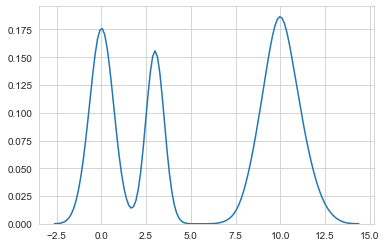

In [16]:
_params_list = [(0, .5), (10, 1), (3, .1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [17]:
print_modelling_and_estimation_results('simple', _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 5.579653090849413
	Mean variance: 0.4939765559159601
	Variance mean: 20.730298815424533
	Variance variance: 3.435661452665917


##### Stratified proportionally

In [18]:
print_modelling_and_estimation_results('stratify_prop', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_prop
Strat samples sizes: [12, 20, 8]
Modelling results
	Mean mean: 5.626817059177997
	Mean variance: 0.013725920182129403
	Variance mean: 21.218855178286628
	Variance variance: 1.1378511378771032
Estimation results
	Mean mean: 4.332551893925664
	Mean variance: 6.579145038793356
	Variance mean: 1.7655197772891396
	Variance variance: 0.008148126771202562


##### Stratified optimally

In [19]:
print_modelling_and_estimation_results('stratify_optimal', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_optimal
Strat samples sizes: [11, 26, 3]
Modelling results
	Mean mean: 6.7599778649656885
	Mean variance: 0.016969270365966543
	Variance mean: 21.367091099102677
	Variance variance: 1.0558705253926268
Estimation results
	Mean mean: 4.479792562263252
	Mean variance: 6.766570070014131
	Variance mean: 2.0135573204589337
	Variance variance: 0.05676985851368808
